# Analyzing NYC High School Data
The SAT is a test that high school seniors in the U.S. take every year. The SAT has three sections; Math, Evidence-based reading and Writing. Each of these are worth a maximum of 800 points. Colleges use the SAT to determine which students to admit.

New York City has published data on student SAT scores by high school, along with additional demographic data sets that is used in this project:
- [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
- [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
- [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
- [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
- [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
- [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
- [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school

This project will combine these data sets and then try and draw some conclusions regarding the relationship between SAT scores and key factors such as location of school, gender percentage, race percentage, AP exams taken and more.

# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

Let's create a bar plot visualizing the correlations between `sat_score` and the different fields from the survey:

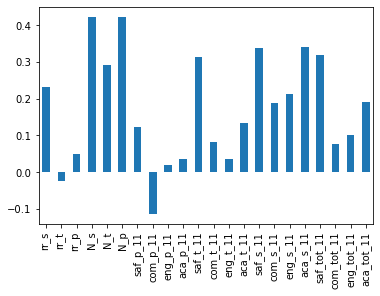

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
combined[survey_fields].corrwith(combined['sat_score']).plot(kind='bar')

To understand the columns there is a dictionary that's part of the zip file you can download from the City of New York's [website](https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8).

There are high correlations between *N_s*, *N_t*, *N_p* and *sat_score*. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

A little more interesting is that *rr_s* (student response rate) has somewhat of a positive correlation with *sat_score*. This could be a result of students on average being more likely to complete surveys if they are academically gifted and thus scoring higher on the SATs.

*saf_t_11* and *saf_s_11* (Safety and Respect score based on teacher respectively student responses) also seem to have a high correlation with *sat_score*. About equally as strong, as to be expected, is *saf_tot_11* (Safety and Respect total score). This seems reasonable as it is hard to learn and teach in an enviroment percieved as unsafe.

Another one of the stronger positive correlations is with *aca_s_11* (Academic expectations score based on student responses). However, a similar correlation is not present in the corresonding columns for teacher respectively parent respondants.

# Exploring safety and respect
As mentioned above, safety and respect scores for both teachers and students are positvely correlating factors with regards to SAT score. Let's explore this in greater detail:

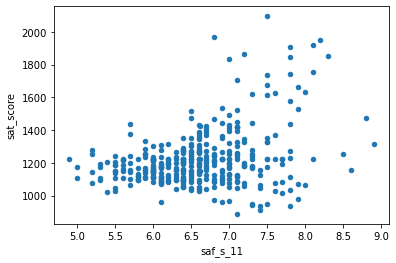

In [12]:
combined.plot(kind='scatter', x='saf_s_11', y='sat_score')
plt.show()

Observations:
- There are tendencies of positive correlation, as earlier determined.
- The SAT score-variations seem to increase as we reach higher values of safety and respect. Most notably, we see a drastically increase variance from around 7.0 and beyond.
- Observations are concentrated around 5.0-7.0 *saf_s_11* and become more sparse beyond that.

### Safety scores mapped
Let's compute average safety scores for each district and map them by district.

In [13]:
grouped = combined.groupby('school_dist')
districts = grouped.agg(np.mean)
districts.head()

,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,NUMBER OF STUDENTS / SEATS FILLED,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
school_dist,,,,,,,,,,,,,,,,,,,,,
01,441.833333,473.333333,439.333333,1354.500000,116.681090,173.019231,135.800000,93.500000,1.0,115.244241,...,12.0,12.0,10003.166667,659.500000,1.333333,0.0,0.0,0.0,40.719022,-73.982377
02,426.619092,444.186256,424.832836,1295.638184,128.908454,201.516827,157.495833,158.647849,2.0,149.818949,...,12.0,12.0,10023.770833,621.395833,1.416667,0.0,0.0,0.0,40.739699,-73.991386
03,428.529851,437.997512,426.915672,1293.443035,156.183494,244.522436,193.087500,183.384409,3.0,156.005994,...,12.0,12.0,10023.750000,717.916667,2.000000,0.0,0.0,0.0,40.781574,-73.977370
04,402.142857,416.285714,405.714286,1224.142857,129.016484,183.879121,151.035714,113.857143,4.0,132.362265,...,12.0,12.0,10029.857143,580.857143,1.142857,0.0,0.0,0.0,40.793449,-73.943215
05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,120.623901,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251


C:\Users\karla\anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
C:\Users\karla\anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


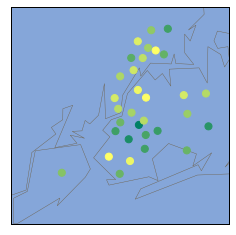

In [14]:
from mpl_toolkits.basemap import Basemap

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, s=50, zorder=2, latlon=True, c=districts['saf_s_11'], cmap='summer')

It appears Manhattan and parts of Queens and the Bronx tend to have higher safety scores, whereas large parts of Brooklyn has low safety scores.

# SAT scores and race
Another interesting aspect is the correlation between race and SAT scores. Let's explore that next.

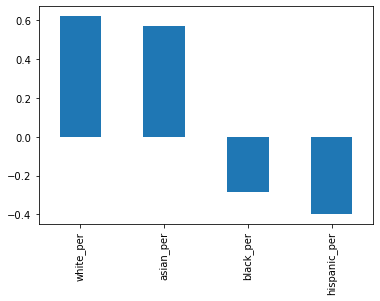

In [15]:
combined[['white_per', 'asian_per', 'black_per', 'hispanic_per']].corrwith(combined['sat_score']).plot(kind='bar')

Here a couple of clear observations can be made:
- White and asian ethnicity positively correlates relatively strongly with SAT scores.
- Black and hispanic ethnicity negatively correlates with SAT scores.

Why this is is a complex question where socio-economic circumstances probably plays a part.

The race that negatively correlates the strongest with SAT scores is hispanic. Let's look closer at this ethnicity:

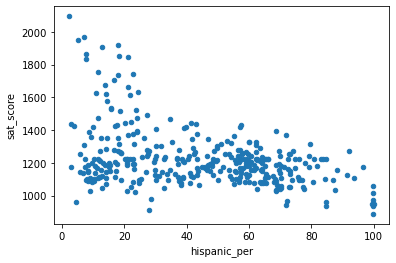

In [16]:
combined.plot(kind='scatter', x='hispanic_per', y='sat_score')

Looking at this plot, the negative correlation becomes very apparent. The higher share of hispanic students, the lower SAT scores tend to be. Looking at the extreme of schools with around 100% hispanics, these all perform very poorly on the SAT:s.

Let's look at schools with over 95% hispanics for a bit and see what we can observe:

In [17]:
combined.loc[combined['hispanic_per'] > 95, 'SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Researching the listed schools they primarily seem to be geared towards recent immigrants. Therefore, students likely possess relatively low language skills which can contribute to low SAT scores.

Let's look at the other extreme; schools with low hispanic percentage and high SAT scores:

In [18]:
print(combined[(combined["hispanic_per"] < 10) & (combined["sat_score"] > 1800)]["SCHOOL NAME"])

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


Reading about the schools above, the appear to be specialized science and technology and therefore receive increased funding. Also, they only admit students who first pass an entrance exam. This doesn't explicitly explain the low hispanic_per in these schools, but it could explain why their students do well on the SATs - the students come from all over New York City and have to pass an exam to be admitted, and passing that exam probably correlates with performing well on the SATs.

# SAT scores and gender

Let's continue to explore the relationship between SAT scores and gender. This is done in a fashion similar to before:

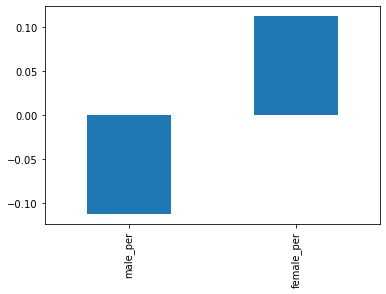

In [19]:
combined[['male_per', 'female_per']].corrwith(combined['sat_score']).plot(kind='bar')

There seem to be a slight negative correlation between percentage of male students and vice versa. You often hear in the media that girls achieve higher grades than boys on average so it's no surprise that better grades to some degree correlates with higher SAT score, which here is implied. Neither correlation is however particularly strong.

Let's plot female percentage vs SAT score:

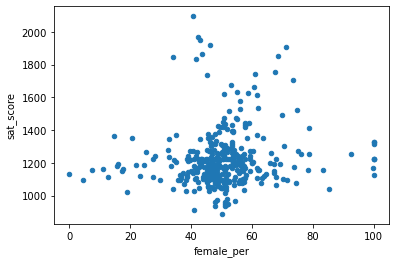

In [20]:
combined.plot(kind='scatter', x='female_per', y='sat_score')

Comparing the extremes it looks as though the female-only schools on average have slightly higher SAT scores compared to those with very low percentage of females. However, most schools are centered around 30-70% and this is also were both the highest SAT scores as well as lowest are located. Looking at the general theme of the plot, it appears SAT scores are a bit higher when female percentage is higher, which confirms the slightly positive correlation between the two.

Let's examine the schools with a female percentage greater than 60% and a high SAT score, say greater than 1700:

In [21]:
combined.loc[(combined['female_per'] > 60) & (combined['sat_score'] > 1700), 'SCHOOL NAME']

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

Reading about these schools, they seem to be very selective liberal arts schools with high academic standards.

# SAT scores and AP exams
In the U.S., high school students take Advanced Placement (AP) exams in many different subjects to earn college credit. It makes sense to assume that the number of students at a school who took AP exams are correlated with its average SAT score.

We want to explore this relationship further. Remember that total enrollment is highly correlated with SAT score. Therefore, we need to be careful to not include this bias in our analysis. To counter this, we will look at the percentage of students in a school that took at least one AP exam.

In [22]:
combined['ap_per'] = combined['AP Test Takers ']/combined['total_enrollment']

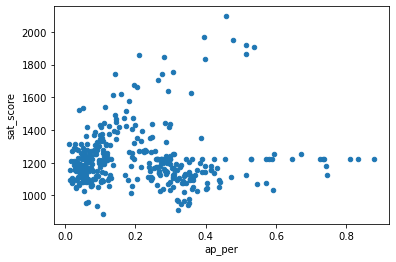

In [23]:
combined.plot(kind='scatter', x='ap_per', y='sat_score')

There seems to be some degree of correlation between the two. There is a very obvious pattern forming for parts of the data, where higher *ap_per* corresponds to higher *sat_score* in an almost linear fashion.

However, for large parts of the data there seems to be no special relationship. For example, there are multiple schools around 1200 SAT score scattered all over the *ap_per* axis.

There seems to be some positive correlation between the percentage taking AP exams and SAT score. However, the correlation is not particularily strong.

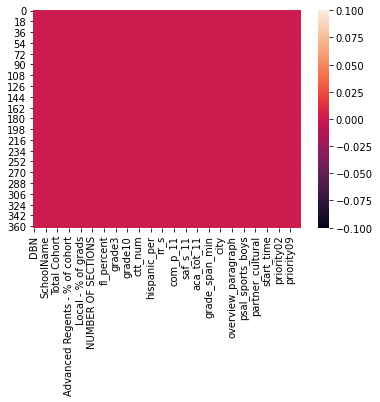

In [24]:
import seaborn as sns

sns.heatmap(combined.isnull())